In [1]:
import matplotlib.pyplot as plt
import scipy as sp
from scipy import linalg
from tqdm import tqdm
import scipy.sparse.linalg as sp_linalg
import numpy as np

# 1

In [2]:
def get_m(n, m):
    M = np.zeros((n*m, n*m))
    
    for i in range(n*m):        
        t = 0
        # right
        if not ((i + 1) % m == 0):
            t += 1
            M[i][i + 1] = 1
        # left
        if not (i % m == 0):
            t += 1
            M[i][i - 1] = 1
        # top
        if not (i - m < 0):
            t += 1
            M[i][i - m] = 1
        # bottom
        if not (i + m >= n * m):
            t += 1
            M[i][i + m] = 1
            
        M[i][i] = -4
        
    return M

In [3]:
ex = get_m(3, 3)
print(ex)

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


In [9]:
def get_eig(n_M, L, N, sort=False):
    delta_x = L/N
    
    M = 1/delta_x**2 * n_M
    
    e_values, e_vectors = sp.linalg.eig(M)
    
    e_values = np.sqrt(np.abs(e_values))
    e_vectors = e_vectors.T
    
    return e_values, e_vectors

In [10]:
def sort_eigs(values, vectors):    
    l = sorted(zip(values, vectors), key = lambda x: x[0])
    return zip(*l)

### Square

In [11]:
N = 50
square_m = get_m(N, N)

In [12]:
square_e_values, square_e_vectors = get_eig(square_m, 1, N)
square_e_values, square_e_vectors = sort_eigs(square_e_values, square_e_vectors)

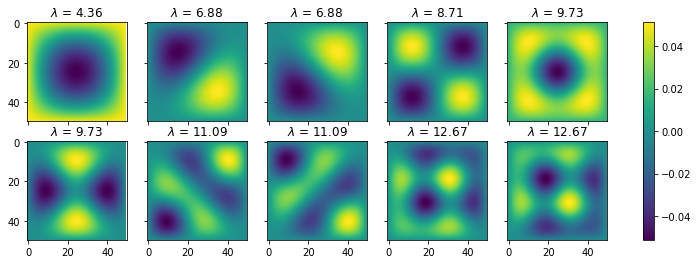

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 4), sharex='col', sharey='row')

for i in range(10):    
    ax = axes.flat[i]
    im = ax.imshow(square_e_vectors[i].reshape(50, 50), interpolation="spline36")
    ax.set_title(r"$\lambda$ = " + str(round(square_e_values[i], 2)))
    ax.grid('off')
    
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig("square_eigenvectors.pdf")

## Rect

In [14]:
N = 50
rect_m = get_m(N, 2*N)
rect_e_values, rect_e_vectors = get_eig(rect_m, 1, N)

In [15]:
rect_e_values, rect_e_vectors = sort_eigs(rect_e_values, rect_e_vectors)

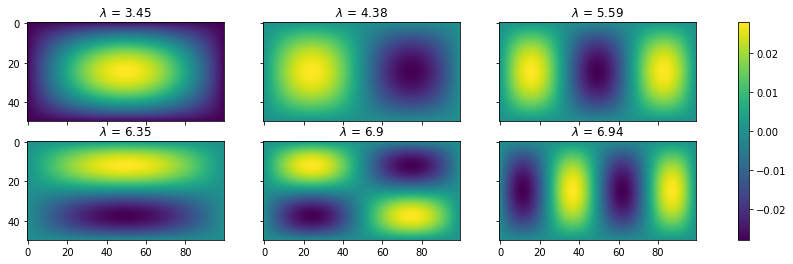

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 4), sharex='col', sharey='row')

for i in range(6):    
    ax = axes.flat[i]
    im = ax.imshow(rect_e_vectors[i].reshape(50, 100), interpolation="spline36")
    ax.set_title(r"$\lambda$ = " + str(round(rect_e_values[i], 2)))
    ax.grid('off')

fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig("rect_eigenvectors.pdf")

### Circle

In [19]:
def to_1d(pos, n):
    x, y = pos
    return x*n + y

def get_circle(N, L=1):
    mask = np.zeros((N, N))

    rad = L / 2
    
    mid = (N-1)/2
    
    for x in range(N):
        for y in range(N):
            if ((x - mid) * (x - mid) + (y - mid) * (y - mid) <= rad * rad): 
                mask[x][y] = 1

    M = np.zeros((N*N, N*N))
                
    for i in range(N):
        for j in range(N):
            current = i, j
            
            if mask[current] == 1:   

                left = i, j-1
                right = i, j+1
                top = i-1, j
                bottom = i+1, j
                
                neighbors = [right, top, left, bottom]
                
                candidates = []                
                for neighbor in neighbors:
                    if (neighbor[0] >= 0 and neighbor[0] < N) and (neighbor[1] >= 0 and neighbor[1] < N):
                        candidates.append(neighbor)
                    
                for c in candidates:
                    if mask[c] == 1:
                        M[to_1d(current, N)][to_1d(c, N)] = 1
                        
                M[to_1d(current, N)][to_1d(current, N)] = -4
                        
    return mask, M

In [20]:
mask, circle_m = get_circle(50, 49)

In [21]:
c_e_values, c_e_vectors = get_eig(circle_m, 1, N)
# remove for all eigenvalue of 0
c_e_values, c_e_vectors = sort_eigs(c_e_values[np.where(c_e_values > 0)], c_e_vectors[np.where(c_e_values > 0)])

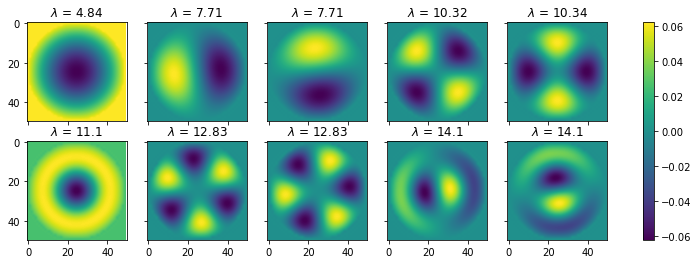

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 4), sharex='col', sharey='row')

for i in range(10):    
    ax = axes.flat[i]
    im = ax.imshow(np.real(c_e_vectors[i]).reshape(50, 50), interpolation="spline36")
    ax.set_title(r"$\lambda$ = " + str(round(c_e_values[i], 2)))
    ax.grid('off')
    
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig("circle_eigenvectors.pdf")

In [25]:
def get_eig_sh(n_M, L, N):
    delta_x = L/N
    
    M = 1/delta_x**2 * n_M
    
    e_values, e_vectors = sp_linalg.eigsh(sp.sparse.csr_matrix(M), k=100, which="SM")
    
    e_values = np.sqrt(np.abs(np.real(e_values)))
    e_vectors = e_vectors.T
    
    return e_values, e_vectors

In [26]:
import time

regular = []
sparse = []

for i in range(5):
    start = time.time()
    sh_val, _ = get_eig(square_m, 1, 50)
    regular.append(time.time() - start)

    start = time.time()
    sh_val, _ = get_eig_sh(square_m, 1, 50)
    sparse.append(time.time() - start)

KeyboardInterrupt: 

In [23]:
print("Avg time (rep = 5), for computing eigenvalues of square (50x50)")
print("Regular: " + str(np.mean(regular)))
print("Sparse: " + str(np.mean(sparse)))
print(regular)
print(sparse)

Avg time (rep = 5), for computing eigenvalues of square (50x50)
Regular: 11.329634475708009
Sparse: 0.23697710037231445
[10.349756479263306, 9.952157974243164, 10.723844766616821, 11.561766624450684, 14.060646533966064]
[0.20148301124572754, 0.22890996932983398, 0.20496034622192383, 0.32413458824157715, 0.22539758682250977]


## Eigenfrequencies vs L (square)

In [29]:
ls = np.arange(1, 9)

s_freqs = []

for l in tqdm(ls):
    values, _ = get_eig(square_m, l, 50)
    s_freqs.append(values)

100%|██████████| 8/8 [03:13<00:00, 29.31s/it]


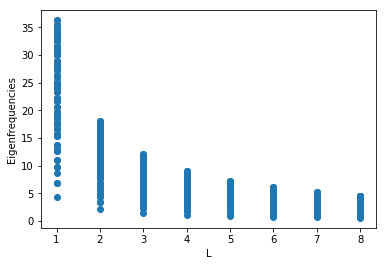

In [28]:
xs = []
ys = []

for i in range(len(s_freqs)):
    for j in range(len(s_freqs[i])):
        xs.append(s_freqs[i][j])
        ys.append(ls[i])
        
    
plt.scatter(ys, xs)
#plt.title("Eigenfrequencies for square (50x50)")
plt.xlabel("L")
plt.ylabel("Eigenfrequencies")
plt.savefig('L-lambda.pdf')
plt.show()

# Eigenfrequencies vs N (square)

In [ ]:
ns = np.arange(10, 50)
L = 1

s_freqs = []

for N in tqdm(ns):
    square_m = get_m(N, N)
    values, _ = get_eig(square_m, L, N)
    s_freqs.append(values)

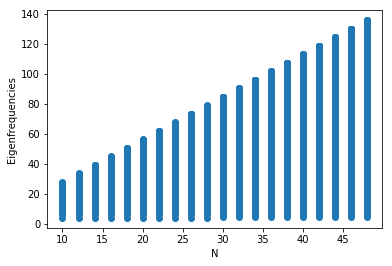

In [61]:
xs = []
ys = []

for i in range(len(s_freqs)):
    for j in range(len(s_freqs[i])):
        if i%2 ==0:
            xs.append(s_freqs[i][j])
            ys.append(ns[i])
        
    
plt.scatter(ys, xs)
#plt.title("Eigenfrequencies for square (50x50)")
plt.xlabel("N")
plt.ylabel("Eigenfrequencies")
plt.savefig('L-N.pdf')
plt.show()

# Eigenfrequencies vs L (circle)

In [46]:
c_freqs = []

for l in tqdm(ls):
    values, k = get_eig(circle_m, l, 50)
    c_freqs.append(values)

100%|████████████████████████████████████████████████| 8/8 [01:15<00:00,  9.51s/it]


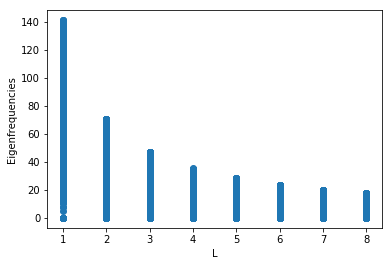

In [47]:
xs = []
ys = []

for i in range(len(c_freqs)):
    for j in range(len(c_freqs[i])):
        xs.append(c_freqs[i][j])
        ys.append(ls[i])
        
plt.scatter(ys, xs)
#plt.title("Eigenfrequencies for circle (50x50, radius=49)")
plt.xlabel("L")
plt.ylabel("Eigenfrequencies")
plt.savefig("L-lambda(circle).pdf")
plt.show()

In [48]:
ns = np.arange(10, 50)
L = 1

s_freqs = []

for N in tqdm(ns):
    values, _ = get_eig(circle_m, L, N)
    s_freqs.append(values)

100%|██████████████████████████████████████████████| 40/40 [06:41<00:00,  9.29s/it]


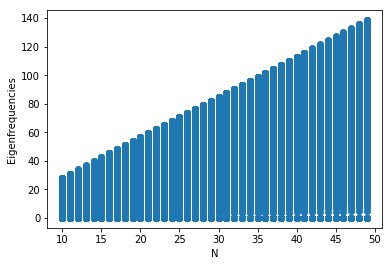

In [52]:
xs = []
ys = []

for i in range(len(s_freqs)):
    for j in range(len(s_freqs[i])):
        xs.append(s_freqs[i][j])
        ys.append(ns[i])
        
plt.scatter(ys, xs)
#plt.title("Eigenfrequencies for square (50x50)")
plt.xlabel("N")
plt.ylabel("Eigenfrequencies")
plt.savefig('L-N(circle).pdf')
plt.show()

# L vs eigenfrequencies (rectangle)

In [55]:
r_freqs = []

for l in tqdm(ls):
    values, k = get_eig(rect_m, l, 50)
    r_freqs.append(values)

100%|████████████████████████████████████████████████| 8/8 [11:40<00:00, 91.91s/it]


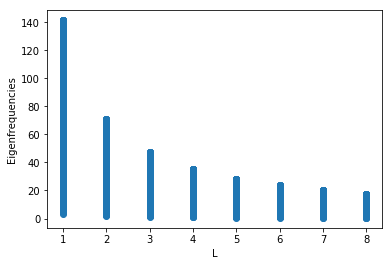

In [63]:
xs = []
ys = []

for i in range(len(r_freqs)):
    for j in range(len(r_freqs[i])):
        xs.append(r_freqs[i][j])
        ys.append(ls[i])
        
    
plt.scatter(ys, xs)
#plt.title("Eigenfrequencies for square (50x50)")
plt.xlabel("L")
plt.ylabel("Eigenfrequencies")
plt.savefig('L-lambda(rectangle).pdf')
plt.show()

# Time comparison

In [66]:
import time

regular_square = []
regular_circle = []
regular_rect = []
sparse_square = []
sparse_circle = []
sparse_rect = []

start = time.time()
sh_val, _ = get_eig(square_m, 1, 50)
regular_square = time.time() - start

start = time.time()
sh_val, _ = get_eig_sh(square_m, 1, 50)
sparse_square = time.time() - start

start = time.time()
sh_val, _ = get_eig(circle_m, 1, 50)
regular_circle = time.time() - start

start = time.time()
sh_val, _ = get_eig_sh(circle_m, 1, 50)
sparse_circle = time.time() - start

start = time.time()
sh_val, _ = get_eig(rect_m, 1, 50)
regular_rect = time.time() - start

start = time.time()
sh_val, _ = get_eig_sh(rect_m, 1, 50)
sparse_rect = time.time() - start

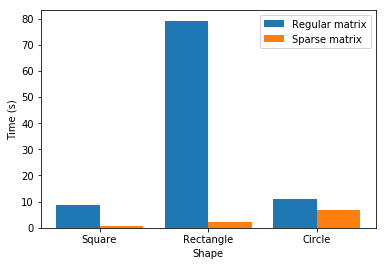

In [68]:
shapes = ('Square', 'Rectangle', 'Circle')
heights = [regular_square, regular_rect, regular_circle]
heights_space = [sparse_square, sparse_rect, sparse_circle]
barWidth = 0.4
y_pos = np.arange(1, 4)
y_pos_2 = np.arange(1, 4) + 0.4

plt.bar(y_pos, heights, width = barWidth, label='Regular matrix')
plt.bar(y_pos_2, heights_space, width = barWidth, label='Sparse matrix')
plt.xticks([1.2, 2.2, 3.2], shapes)
plt.xlabel('Shape')
plt.ylabel('Time (s)')
plt.legend()
plt.savefig('regular-sparse-methods.pdf')
plt.show()

## 1D

In [258]:
from matplotlib import animation

def animate(images, name, interval=50, cmap=mycmap, min2=0, max2=1):
    fig = plt.figure()

    ims = []
    for img in images:
        im = plt.imshow(img, animated=True, vmin=min2, vmax=max2)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=1000)

    ani.save(name)

In [118]:
def T(t, lam):
    A = 1
    B = 1
    c = 1
    
    return A * np.cos(c * lam * t) + B * np.sin (c * lam * t)

In [260]:
iteration = 1

ts = np.linspace(0, 2*np.pi, 100)
times = T(ts, square_e_values[iteration])

first = square_e_vectors[iteration].reshape((50, 50))
vectors = [first]

for t in times:
    vectors.append(t * first)

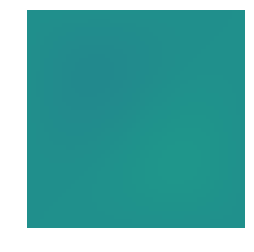

In [261]:
animate(vectors, "test.mp4", min2=np.amin(vectors), max2=np.amax(vectors))

## 2

## 3

/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


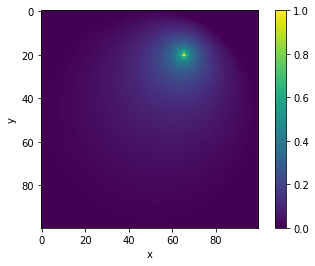

In [65]:
N = 100

m = get_m(N, N)
mask, _ = get_circle(N, N)

radius = 2
source = np.zeros((N, N))
midpoint = int(N/radius), int(N/radius)
source[midpoint[0] - int(N/2/radius * 1.2), midpoint[1] + int(N/2/radius * 0.6)] = 1

for i in range(N):
    for j in range(N):
        if source[i][j] == 1:
            m[i*N+j] = 0
            m[i*N+j][i*N+j] = 1
            
        if mask[i][j] == 0:
            m[i*N+j] = 0
            m[i*N+j][i*N+j] = 1
            
b = source.reshape((N*N))
c = sp_linalg.spsolve(m, b).reshape((N, N))

plt.imshow(c)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()